In [1]:
import sys
sys.path.insert(0,'/client/user1/cuongdev/GenImputation/')
from lib.config.config_class import cpconfig
from transformers import ElectraForMaskedLM, ElectraTokenizer, EvalPrediction
import os
from lib.config.config_class import train_electra_config as teconfig
from lib.config.config_class import TrainModeType, page_config
from lib.data_processing import GenNLPMaskedDataset
from transformers import ElectraForMaskedLM, ElectraTokenizer
from lib.utils import general as g
from lib.model.overwriter import OTrainer
from lib.utils.metrics import eval_metrics
import json
from IPython.display import clear_output
from lib.data_processing import process_ouput as po
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# View train log

In [2]:
paths = [
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_1layer',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_e64',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_nopretrain_long',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_05_lr5',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_05_manny_masked',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_03',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_03_v2',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_05',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_05_v2',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_05_v3',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_08',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_9_10',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_lr5_e10',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_pretrain_origin',
    '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/checkpoints/region0009_same_length',
]
names=['1layer','e64','nopretrain_long','pretrain','05_lr5','05_manny_masked','9_03','9_03_v2','9_05','9_05_v2','9_05_v3','9_08','9_10','lr5_e10','origin','same_length']

In [3]:
data_checkpoints = [cpconfig.get_checkpoint_data(path) for path in paths]

/client/user1/anaconda3/envs/GenImputation/lib/python3.8/site-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type best_metric detected when decoding CheckpointLogConfig.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)
/client/user1/anaconda3/envs/GenImputation/lib/python3.8/site-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type best_model_checkpoint detected when decoding CheckpointLogConfig.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)


In [4]:
train_logs = [checkpoint.get_train_log() for checkpoint in data_checkpoints]
eval_logs = [checkpoint.get_eval_log() for checkpoint in data_checkpoints]

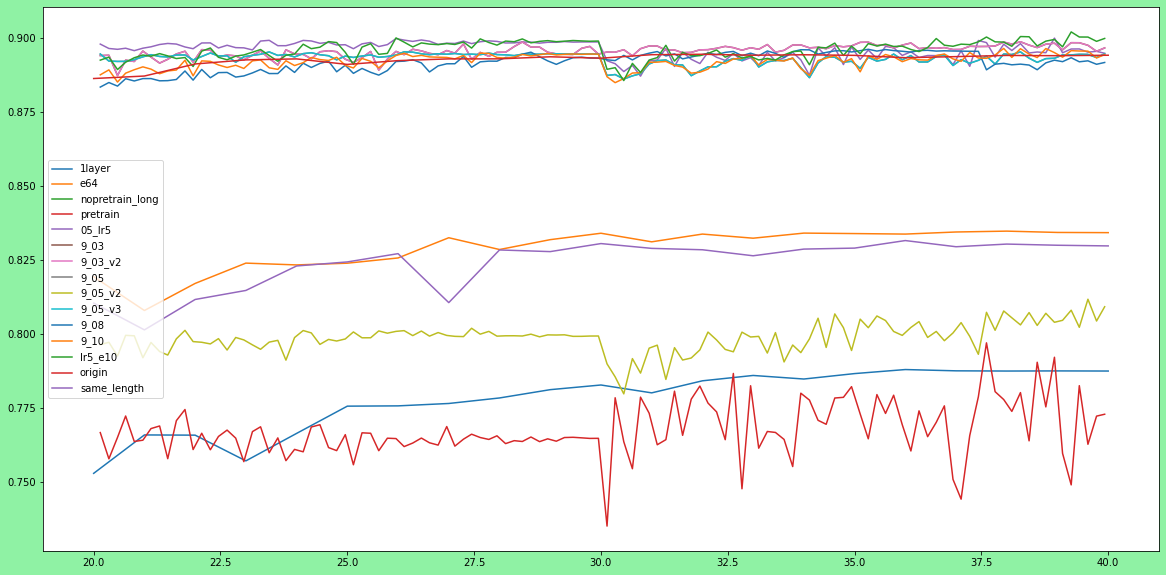

In [5]:
po.plot_log_data(
    eval_logs,
    [eval_metrics.get_score_key(eval_metrics.r2_vs)],
    names=names,from_step=20,to_step=40,
    exclude_names=['05_manny_masked']
)

# View true score to compare

In [3]:
# Get model and calculate score
config_path = '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/config_pretrain_v2.json'
config = teconfig.load_from_json(config_path)
regions = config.regions
batchs = config.batchs
detail = config.model_name
mode = config.mode

masked_mode = config.masked_mode

test_region_paths = page_config.get_file_paths(config.file_test_prefix,page_config.page,regions,[0])
vocab_file = '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/data_dir/vocab.txt'
save_dir_format = config.save_dir_format+detail
pretrain_path_format = config.pretrain_path_format if config.pretrain_path_format is not None else save_dir_format
tokenizer = ElectraTokenizer(vocab_file=vocab_file)
seed = config.seed

key = eval_metrics.get_score_key(eval_metrics.pearsonr_pred)
scores = []
eval_logs = []

/client/user1/anaconda3/envs/GenImputation/lib/python3.8/site-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type resume_from_checkpoint_format detected when decoding TrainElectraArguments.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)
/client/user1/anaconda3/envs/GenImputation/lib/python3.8/site-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type pretrain_path_format detected when decoding TrainElectraArguments.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)


### Get best model

In [ ]:
for i, region in enumerate(regions):
    clear_output(wait=True)
    print('Region {} viewing...'.format(region))
    # train arg and model arg
    func_format = teconfig.get_func_format(region,detail)
    training_args = config.get_trainning_args(func_format)
    checkpoint_dir = training_args.output_dir
    ## test data
    test_batch_paths = test_region_paths[i]
    test_dataset = GenNLPMaskedDataset(test_batch_paths,tokenizer,seed=seed,masked_by_flag=True,only_input=True,force_create=True)
    ## model
    checkpoint_path, eval_log = cpconfig.get_best_model_from_checpoint(checkpoint_dir,key = key)
    eval_logs.append(eval_log)
    electra_model = ElectraForMaskedLM.from_pretrained(checkpoint_path)
    input_ids=test_dataset.maskeds['input_ids']
    output_model = electra_model(input_ids=input_ids)
    output_model = EvalPrediction(predictions=output_model.logits,label_ids=test_dataset.labels)
    score = eval_metrics.get_score_transformers(output_model,input_ids,tokenizer,True)
    score['region'] = region
    score['epoch']=eval_log.epoch
    scores.append(score)
    print('Region {} viewed'.format(region))
    del electra_model
    del output_model
    del test_dataset

In [3]:
paper_score = pd.read_csv('/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/paper_scores.txt',sep=' ',header=None)[2].values
paper_score = pd.DataFrame({"region":np.arange(len(paper_score)),"paper_score":paper_score})

In [4]:
own_score = pd.DataFrame(scores)

In [5]:
own_score.merge(paper_score,how='inner',on='region')

,R2 score VS,R2 score SV,R2 score sum,R2 score pred,Pearsonr VS,Pearsonr pred,region,epoch,paper_score
0,0.616518,0.379722,0.996240,0.566408,0.655036,0.616765,1,283.69,0.567505
1,0.743639,0.490896,1.234535,0.712559,0.763934,0.737553,2,251.41,0.728557
2,0.892393,0.731667,1.624059,0.871429,0.902094,0.884336,3,292.68,0.903726
3,0.846046,0.716906,1.562952,0.811586,0.856986,0.828836,4,293.34,0.847839
4,0.927071,0.823214,1.750285,0.875304,0.938997,0.919212,5,250.08,0.917143
5,0.948141,0.876651,1.824792,0.915006,0.951526,0.924479,6,260.23,0.919279
6,0.916039,0.835071,1.751110,0.880344,0.924289,0.896875,7,252.08,0.907141
7,0.814932,0.647953,1.462885,0.741081,0.831550,0.770983,8,282.36,0.806803
8,0.887536,0.765254,1.652790,0.836925,0.896044,0.854249,9,294.51,0.866707
9,0.956608,0.891054,1.847661,0.936646,0.961579,0.947236,10,280.20,0.942761


### View score each region

Region 1 viewing...


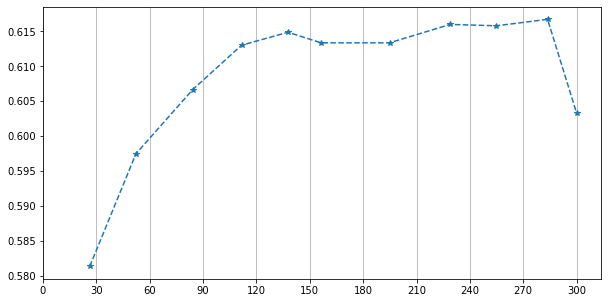

Region 2 viewing...


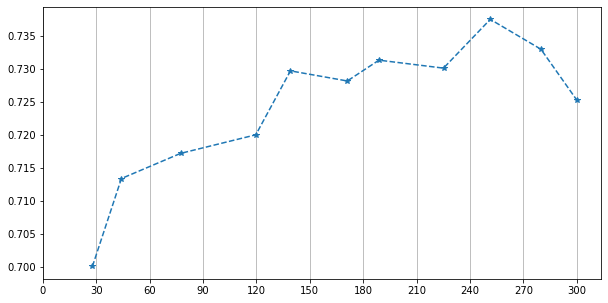

Region 3 viewing...


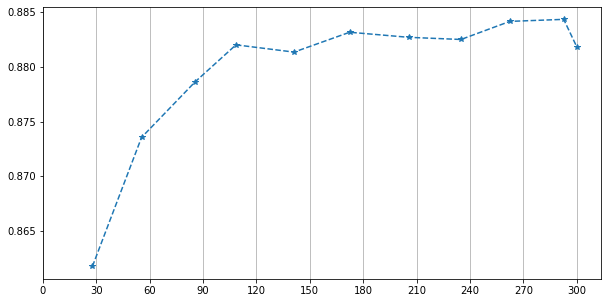

Region 4 viewing...


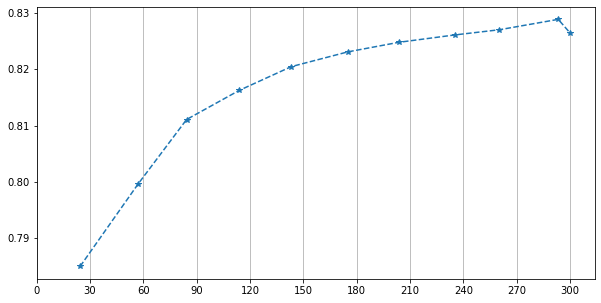

Region 5 viewing...


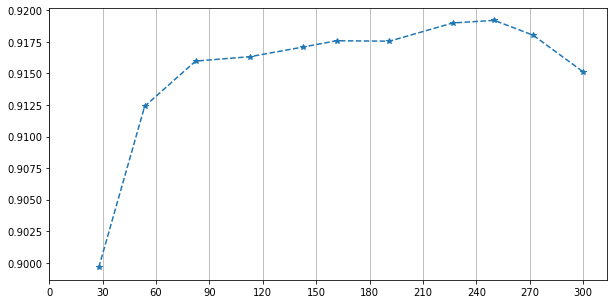

Region 6 viewing...


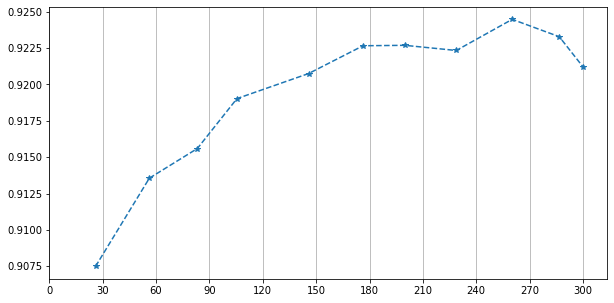

Region 7 viewing...


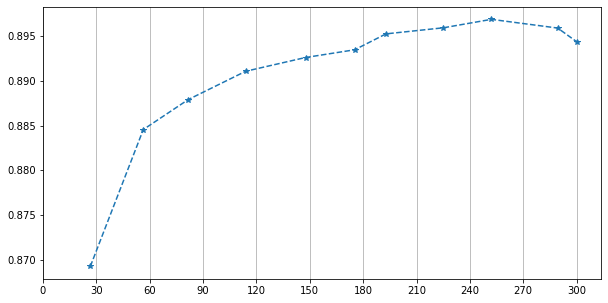

Region 8 viewing...


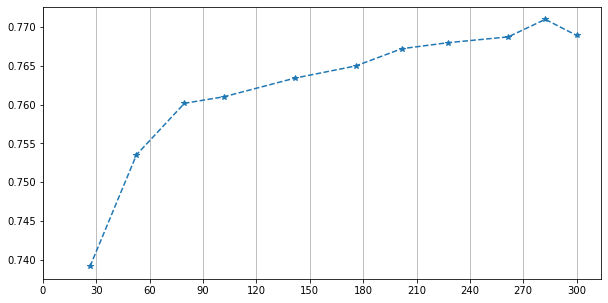

Region 9 viewing...


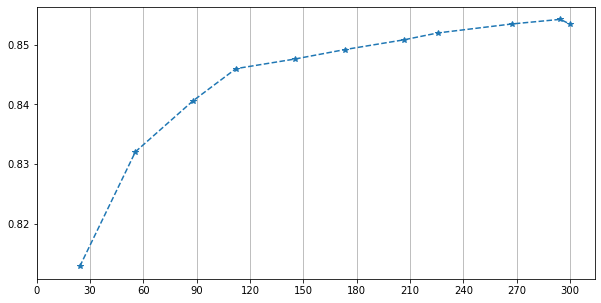

Region 10 viewing...


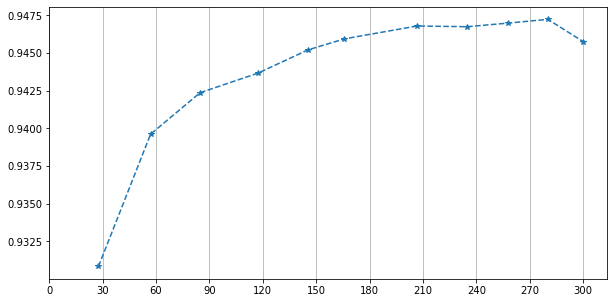

Region 11 viewing...


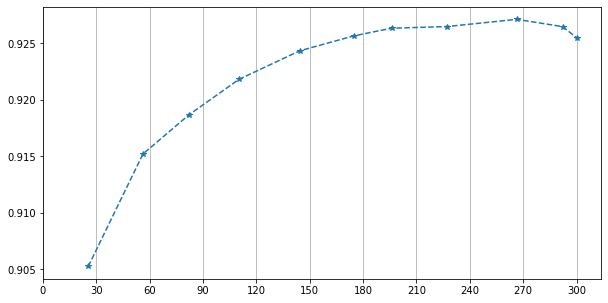

Region 12 viewing...


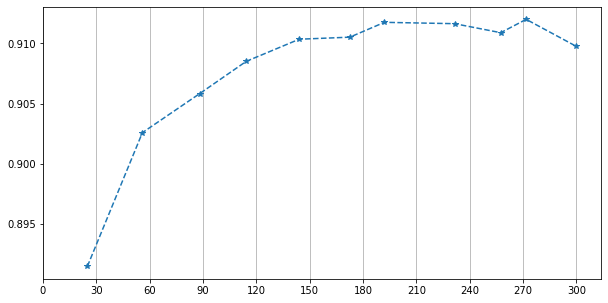

In [12]:
for i, region in enumerate(regions):
    print('Region {} viewing...'.format(region))
    # train arg and model arg
    func_format = teconfig.get_func_format(region,detail)
    training_args = config.get_trainning_args(func_format)
    checkpoint_dir = training_args.output_dir
    data = cpconfig.get_best_score_each_cycle(checkpoint_dir,key,training_args.num_cycles)
    scores = [d.get_score(key) for d in data]
    epochs = [d.epoch for d in data]
    plt.figure(figsize=(10,5))
    plt.plot(epochs,scores,'--*')
    plt.xticks(np.arange(epochs[-1]+30,step=30))
    plt.grid(axis='x')
    plt.show()